# Cats and Dogs Classification

In [1]:
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from glob import glob
from PIL import Image
from tqdm import tqdm

## 1. Подготовьте датасет, разделите на тест и трейн. Можете использовать сабсемпл (не менее 200 изображений на класс, лучше больше). Для того, чтобы было иллюстративнее, миожете отобрать изображения по вкусу.

In [2]:
# Размер до которого уменьшаем изображения
IMG_SIZE = 64

def load_images_from_folder(folder, label, max_images=None):
    images = []
    labels = []
    files = glob(os.path.join(folder, '*.jpg'))
    if max_images:
        files = files[:max_images]
    for filename in tqdm(files):
        try:
            img = Image.open(filename).convert('L')  # Чёрно-белое
            img = img.resize((IMG_SIZE, IMG_SIZE))
            img_array = np.array(img).flatten()
            images.append(img_array)
            labels.append(label)
        except:
            continue
    return images, labels

In [3]:
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
print("Путь к датасету:", path)

Путь к датасету: /kaggle/input/dog-and-cat-classification-dataset


In [4]:
cat_images, cat_labels = load_images_from_folder(os.path.join(path, 'PetImages/Cat'), 0, max_images=1000)
dog_images, dog_labels = load_images_from_folder(os.path.join(path, 'PetImages/Dog'), 1, max_images=1000)

X = np.array(cat_images + dog_images)
y = np.array(cat_labels + dog_labels)

100%|██████████| 1000/1000 [00:08<00:00, 118.02it/s]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

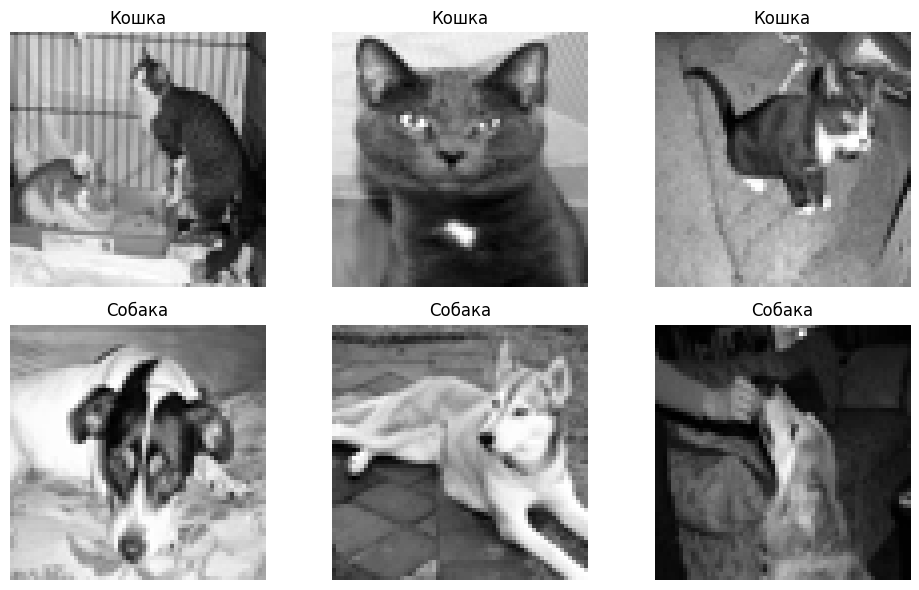

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for i in range(3):
    axs[0, i].imshow(X[y == 0][i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    axs[0, i].set_title("Кошка")
    axs[1, i].imshow(X[y == 1][i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    axs[1, i].set_title("Собака")
    for j in range(2):
        axs[j, i].axis('off')
plt.tight_layout()
plt.show()

## 2. Обучите классификатор или несколько на исходных изображениях (можете еще сильнее сжать изображения)

In [7]:
print("Базовая логистическая регрессия без PCA")
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])
pipeline.fit(X_train, y_train)
print("Точность (без PCA):", accuracy_score(y_test, pipeline.predict(X_test)))

Базовая логистическая регрессия без PCA
Точность (без PCA): 0.515


## 3. Сделайте PCA и снова обучите классификатор

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA().fit(X_scaled)

## 4. Постройте график зависимости качества классификации от числа компонент

In [9]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumsum >= 0.9) + 1

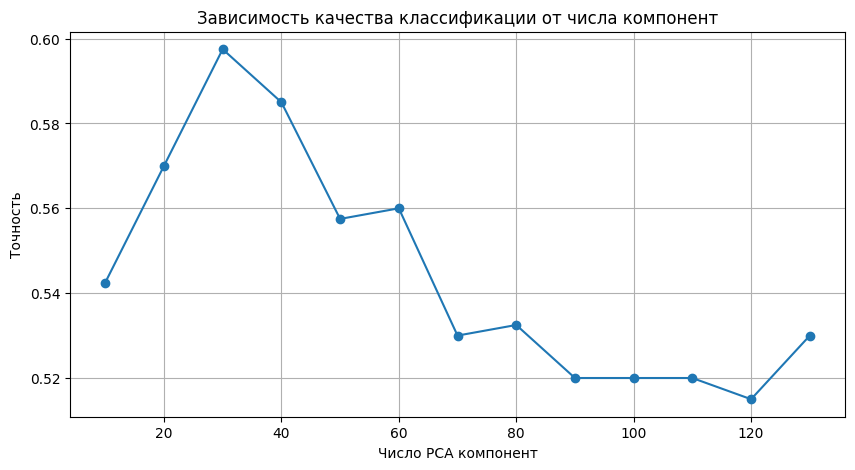

In [10]:
accuracies = []
components_range = list(range(10, n_components_90 + 1, 10))
for n in components_range:
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(scaler.fit_transform(X))
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train_pca, y_train_pca)
    acc = accuracy_score(y_test_pca, clf.predict(X_test_pca))
    accuracies.append(acc)

plt.figure(figsize=(10, 5))
plt.plot(components_range, accuracies, marker='o')
plt.xlabel('Число PCA компонент')
plt.ylabel('Точность')
plt.grid(True)
plt.title('Зависимость качества классификации от числа компонент')
plt.show()

## 5. Ответьте на вопрос: сколько компонент требуется для объяснения 90% дисперсии?

In [11]:
print(f"Для объяснения 90% дисперсии достаточно {n_components_90} компонент")

Для объяснения 90% дисперсии достаточно 139 компонент


## 6. Нарисуйте график зависимости процента объясненной дисперсии от числа компонент.

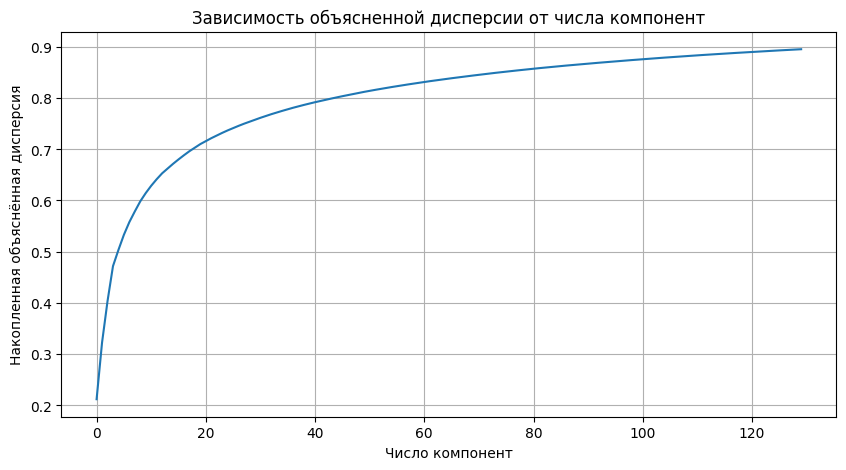

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Число компонент')
plt.ylabel('Накопленная объяснённая дисперсия')
plt.grid(True)
plt.title('Зависимость объясненной дисперсии от числа компонент')
plt.show()

На данном датасете при росте числа компонент увеличивается дисперсия, при этом снижается точность

## 7. Отрисуйте первые 10 главных компонент (или все, если их меньше) для наилучшей точности, полученной вами в тестах.

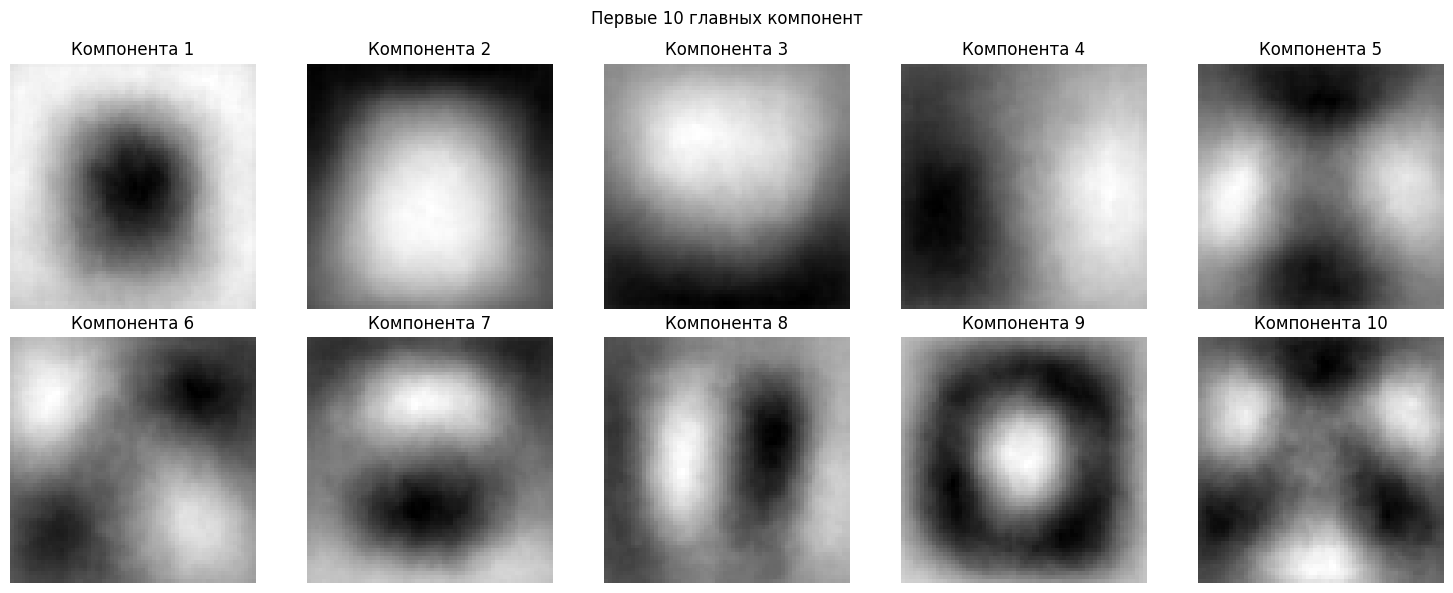

In [13]:
pca = PCA(n_components=10)
pca.fit(scaler.fit_transform(X))
components = pca.components_.reshape((10, IMG_SIZE, IMG_SIZE))

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(components[i], cmap='gray')
    ax.set_title(f"Компонента {i+1}")
    ax.axis('off')
plt.suptitle("Первые 10 главных компонент")
plt.tight_layout()
plt.show()

## Доп. задание. Сравните влияние PCA на разные алгоритмы (линейный, дерево).

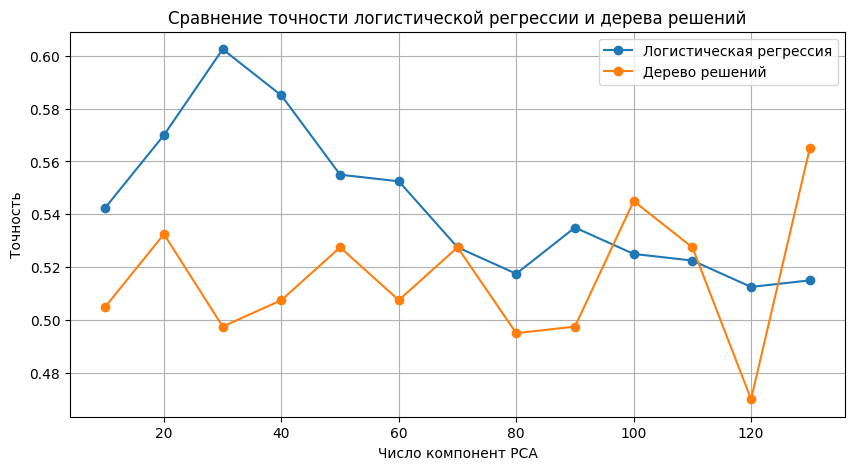

In [14]:
components_range = list(range(10, n_components_90 + 1, 10))
results = {
    'Логистическая регрессия': [],
    'Дерево решений': []
}

for n in components_range:
    X_pca = PCA(n_components=n).fit_transform(scaler.transform(X))
    X_tr, X_te, y_tr, y_te = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

    log = LogisticRegression(max_iter=1000)
    log.fit(X_tr, y_tr)
    results['Логистическая регрессия'].append(accuracy_score(y_te, log.predict(X_te)))

    tree = DecisionTreeClassifier()
    tree.fit(X_tr, y_tr)
    results['Дерево решений'].append(accuracy_score(y_te, tree.predict(X_te)))

plt.figure(figsize=(10, 5))
for name, acc in results.items():
    plt.plot(components_range, acc, marker='o', label=name)

plt.xlabel('Число компонент PCA')
plt.ylabel('Точность')
plt.grid(True)
plt.legend()
plt.title('Сравнение точности логистической регрессии и дерева решений')
plt.show()

При числе компонент меньше 70 логистическая регрессия работает лучше, чем дерево решений